In [1]:
import requests
from bs4 import BeautifulSoup
import pdftotext
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def getPapersForYear(year):
    '''
        Input: year of Proceedings to scrape
        Output: A list of papers, each has the format {"title":, "paper_link":, "supplemental_link":}
    '''
    # Get Links to All Paper Abstracts 
    root_url = "https://proceedings.neurips.cc"
    resp = requests.get(root_url + "/paper/" + str(year))
    
    mainPage_html = BeautifulSoup(resp.content, 'html.parser')
    links = [link["href"] for link in mainPage_html.find_all('a')]
    abstract_links = []
    for link in links:
        if "/paper" in link:
            abstract_links.append(root_url + link)

    papers = []
    for abstract_url in abstract_links:
        try:
            abstract_html = BeautifulSoup(requests.get(abstract_url).content,\
                                         'html.parser')
            paper_title_links = {"title": abstract_html.find('h4').text.strip().replace("/", ":")}
            paper_title_links["year"] = str(year)
            pdf_links = [link["href"] for link in abstract_html.find_all('a')]
            for pdf in pdf_links:
                if "Paper.pdf" in pdf:
                    paper_title_links["paper_link"] = root_url + pdf
                elif "Supplemental.pdf" in pdf:
                    paper_title_links["supplemental_link"] = root_url + pdf
            papers.append(paper_title_links)
        except:
            print(abstract_url)
            continue

    with open("pickles/papers_" + str(year) + ".pickle", "wb") as pickleFile:
        description = "list of paper metadata from Neurips. Each entry is a dictionary containing\
        the paper title, link to paper pdf (if it exists), and link to supplemental materials (if it exists)"
        pickle.dump((description, papers), pickleFile)
    
    return papers

In [3]:
# Within Each Abstract, Download the paper and supplemental materials
def extractTextFromURL(paper):
    pdftxt = ""
    try:
        if "paper_link" in paper:
            #Download PDF
            with open('papers/' + paper["title"] + ".pdf", "wb") as pdfFile:
                rsp = requests.get(paper["paper_link"])
                pdfFile.write(rsp.content)

            #Extract Text
            with open('papers/' + paper["title"] + ".pdf", "rb") as pdfFile:
                pdf = pdftotext.PDF(pdfFile)
                pdftxt += "\n\n".join(pdf)

            #Delete PDF
            os.remove('papers/' + paper["title"] + ".pdf")

        if "supplemental_link" in paper:
            #Download PDF
            with open('supplemental/' + paper["title"] + ".pdf", "wb") as pdfFile:
                rsp = requests.get(paper["supplemental_link"])
                pdfFile.write(rsp.content)

            #Extract Text
            with open('supplemental/' + paper["title"] + ".pdf", "rb") as pdfFile:
                pdf = pdftotext.PDF(pdfFile)
                pdftxt += "\n\n".join(pdf)

            #Delete PDF
            os.remove('supplemental/' + paper["title"] + ".pdf")
    except:
        print("Could not extract text for: " + paper["title"])
    return pdftxt.lower()

In [4]:
def saveBroaderImpact(paper, txt):
    broader_impact_idx = txt.find("broader impact")
    if broader_impact_idx < 0:
        broader_impact_idx = txt.find("broader societal impact")
    if broader_impact_idx < 0:
        print("Could not find Broader Impact section for: " + paper["title"])
        return 
    
    txt = txt[broader_impact_idx:]
    end_idx = len(txt)
    acknowledgement_idx = txt.find("acknowledgement")
    references_idx = txt.find("references")
    if acknowledgement_idx > 0 and references_idx > 0:
        end_idx = min(acknowledgement_idx, references_idx)
    elif acknowledgement_idx > 0:
        end_idx = acknowledgement_idx
    elif references_idx > 0:
        end_idx = references_idx
    
    txt = txt[:end_idx]
    
    with open("papers/" + paper["title"] + ".txt", "w") as txtFile:
        txtFile.write(txt)

In [5]:
def parsePaper(paper, pdftxt, parsed_papers):
    keywords = [\
               ("Github", "github.com"),\
               ("GPU", "gpu"),\
               ("Reproducibility", "reproducibility"),\
               ("Broader Impact", "broader impact")]

    parsed_paper = {"title": paper["title"], "year": paper["year"]}
    for key, value in keywords:
        parsed_paper[key] = int(value in pdftxt)
    parsed_papers.append(parsed_paper)

In [6]:
parsed_papers = []

In [7]:
years = [2020, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011]
for year in years:
    print(str(year))
    papers = getPapersForYear(year)
    print("Finished getting links")
    for paper in papers:
        pdftxt = extractTextFromURL(paper)
        #saveBroaderImpact(paper, pdftxt)
        parsePaper(paper, pdftxt, parsed_papers)
    
    parsed_papers_pd = pd.DataFrame(parsed_papers)
    with open("pickles/neurips_parsed_papers_pd.pickle", "wb") as pickleFile:
        description = "table with statistics of interest for neurips papers. Each paper is a row in which\
        we indicate the desired properties that are satisfied."
        pickle.dump((description, parsed_papers_pd), pickleFile)

2020
Finished getting links
2018
https://proceedings.neurips.cc/paper/2018/hash/74627b65e6e6a4c21e06809b8e02114a-Abstract.html
Finished getting links
2017
Finished getting links
2016
Finished getting links
2015
Finished getting links
2014
Finished getting links
2013
Finished getting links
2012
Finished getting links
2011
Finished getting links


In [8]:
parsed_papers_pd = pd.DataFrame(parsed_papers)
with open("pickles/neurips_parsed_papers_pd.pickle", "wb") as pickleFile:
    description = "table with statistics of interest for neurips 2002 papers. Each paper is a row in which\
    we indicate the desired properties that are satisfied."
    pickle.dump((description, parsed_papers_pd), pickleFile)

In [9]:
with open("pickles/neurips_parsed_papers_pd.pickle", "rb") as pickleFile:
    description, parsed_papers_pd = pickle.load(pickleFile)

parsed_papers_pd.groupby("year").mean()

,Github,GPU,Reproducibility,Broader Impact
year,,,,
2011,0.006536,0.016340,0.003268,0.000000
2012,0.002703,0.035135,0.008108,0.002703
2013,0.025000,0.036111,0.002778,0.000000
2014,0.046229,0.090024,0.002433,0.000000
2015,0.121588,0.104218,0.024814,0.000000
2016,0.186292,0.130053,0.008787,0.000000
2017,0.304860,0.163476,0.011782,0.000000
2018,0.369048,0.193452,0.019841,0.000992
2020,0.560590,0.336143,0.051106,0.987882


Text(0.5, 1.0, 'Fraction of NeurIPS papers containing computing keywords (2011-2020)')

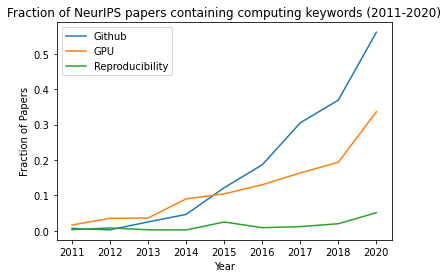

In [10]:
ax = plt.subplot()
parsed_papers_pd[["year", "Github", "GPU", "Reproducibility"]].groupby("year").mean().plot(ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Fraction of Papers")
ax.set_title("Fraction of NeurIPS papers containing computing keywords (2011-2020)")

0                              Compositional Plan Vectors
1           Learning to Propagate for Graph Meta-Learning
2       XNAS: Neural Architecture Search with Expert A...
3          Multi-resolution Multi-task Gaussian Processes
4                                 Deep Equilibrium Models
                              ...                        
7426                Pylon Model for Semantic Segmentation
7427               How biased are maximum entropy models?
7428         Gaussian process modulated renewal processes
7429    An ideal observer model for identifying the re...
7430    Greedy Algorithms for Structurally Constrained...
Name: title, Length: 7431, dtype: object